In [115]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict

from utils import *

In [116]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [117]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Generalized Stitching Configs

In [118]:
def generalized_grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'gcdqn':
        result += 'GCDQN'
    elif config['agent']['agent_name'] == 'clearn_search':
        result += "C-LEARN"
    else:
        result += "CRL"

    result += '_' + str(config['env']['number_of_boxes_max'])

    return result

agents = ['GCDQN', 'C-LEARN', 'CRL']

config_1 = {
    "directory": "main",
    "title": f"main_fugure",
    "projects":["paper_main_fig_exact"],
    "possible_names":['_'.join([agent, s]) for agent in agents for s in [str(i) for i in range(1, 5)]],
    "filters":{
    },
    "grouping_func": generalized_grouping_func,
    "metrics": OrderedDict([
        ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
        ("eval_special/mean_success", "Test success on 3 boxes \n(0 on target)"),
    ]),
}

config_2 = {
    "directory": "main",
    "title": f"main_fugure",
    "projects":["paper_main_fig_generalized"],
    "possible_names":['_'.join([agent, s]) for agent in agents for s in [str(i) for i in range(1, 5)]],
    "filters":{
    },
    "grouping_func": generalized_grouping_func,
    "metrics": OrderedDict([
        ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
        ("eval_4/mean_success", "Test success on 3 boxes \n(0 on target)"),
    ]),
}

all_configs.append(config_1)
# all_configs.append(config_2)


# Plotting

dict_keys(['GCDQN_1_test', 'GCDQN_1_train', 'GCDQN_2_test', 'GCDQN_2_train', 'GCDQN_3_test', 'GCDQN_3_train', 'GCDQN_4_test', 'GCDQN_4_train', 'C-LEARN_1_test', 'C-LEARN_1_train', 'C-LEARN_2_test', 'C-LEARN_2_train', 'C-LEARN_3_test', 'C-LEARN_3_train', 'C-LEARN_4_test', 'C-LEARN_4_train', 'CRL_1_test', 'CRL_1_train', 'CRL_2_test', 'CRL_2_train', 'CRL_3_test', 'CRL_3_train', 'CRL_4_test', 'CRL_4_train'])


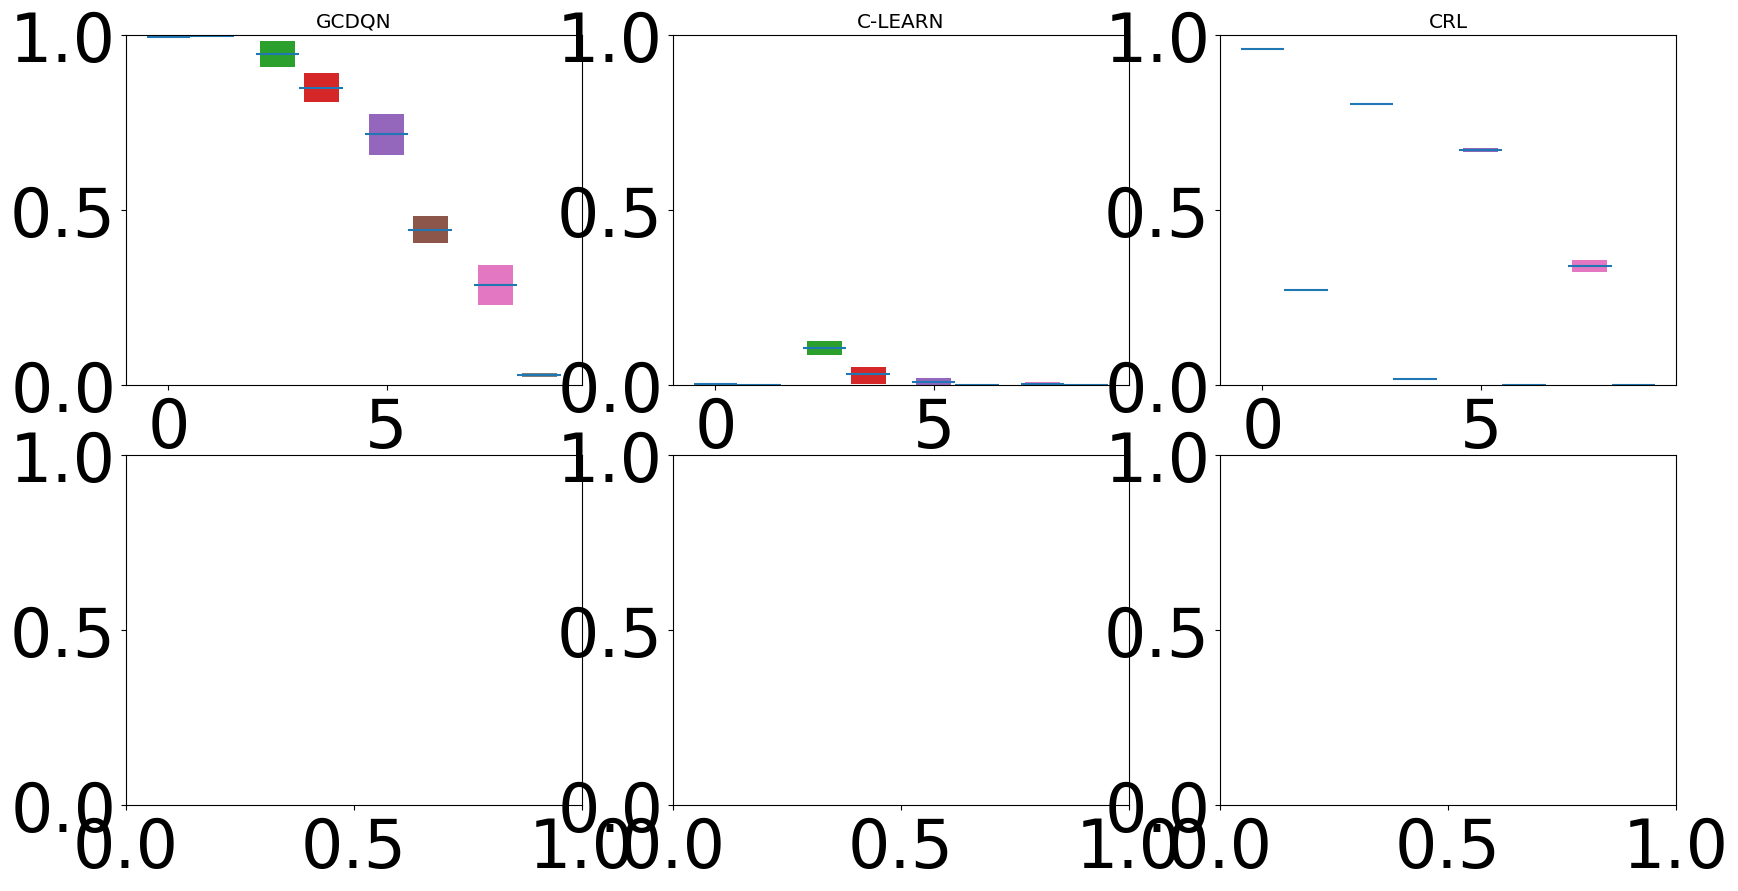

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))

for h_axes, config in zip(axes, all_configs):
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])


    data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        new_data[k + '_test'] = aggregated_v[:, 1].reshape(-1, 1)
        new_data[k + '_train'] = aggregated_v[:, 0].reshape(-1, 1)

    names = list(new_data.keys())

    metrics_names = config['metrics']

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    aggregate_func = lambda x: np.array([metrics.aggregate_iqm(x[:, i]) for i in range(x.shape[-1])])

    aggregate_scores, aggregate_scores_cis = rly.get_interval_estimates(
        new_data, aggregate_func, reps=500
    )

    print(aggregate_scores.keys())

    for ax, alg in zip(h_axes, agents):
        ax.set_title(alg)
        ax.set_ylim(bottom=0.0, top=1.0)
        box_centers = []
        for box_num in range(4):
            box_center = 2.5 * box_num + 0.5
            box_centers.append(box_center)
            ax.hlines(aggregate_scores['_'.join([alg, str(box_num+1), 'train'])], xmin=box_center - 1, xmax=box_center)
            ax.hlines(aggregate_scores['_'.join([alg, str(box_num+1), 'test'])],  xmin=box_center, xmax=box_center+1)

            train_bottom = aggregate_scores_cis['_'.join([alg, str(box_num+1), 'train'])][0]
            train_height = aggregate_scores_cis['_'.join([alg, str(box_num+1), 'train'])][1] - train_bottom

            test_bottom = aggregate_scores_cis['_'.join([alg, str(box_num+1), 'test'])][0]
            test_height = aggregate_scores_cis['_'.join([alg, str(box_num+1), 'test'])][1] - test_bottom

            ax.bar(box_center - 0.5, train_height, bottom=train_bottom)
            ax.bar(box_center + 0.5, test_height, bottom=test_bottom)

